In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-07T17:48:04.838863+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

seaborn   : 0.11.1
matplotlib: 3.3.4
numpy     : 1.20.3
pandas    : 0.25.3



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [8]:
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [9]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5589, 1234), (1398, 1234), (3000, 1230), 0, 1198)

In [10]:
cat_cols = cat_cols + ['category']
print(cat_cols)

['category']


отделяем метки от данных

In [11]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5589, 1231), (1398, 1231), (5589, 3), (1398, 3))

In [12]:
x_train.shape

(5589, 1231)

In [13]:
#cat_cols + num_cols


In [14]:
#views
train_ds_views = Pool(x_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      y_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

val_ds_views   = Pool(x_val[cat_cols + num_cols],
#val_ds_views   = Pool(x_val[cat_cols + ['ctr']],
                      y_val[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )


#depth
train_ds_depth = Pool(x_train[cat_cols + num_cols],
                      y_train[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_depth   = Pool(x_val[cat_cols + num_cols],
                      y_val[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )


#full_reads_percent
train_ds_frp = Pool(x_train[cat_cols + num_cols],
                      y_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_frp   = Pool(x_val[cat_cols + num_cols],
                      y_val[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

In [15]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [16]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [17]:
cb_model_views = CatBoostRegressor(iterations=20,
                                 learning_rate=0.1,
                                 depth=4,
                                 random_seed = CB_RANDOMSEED,
                   #n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_ds_views,
        #train_data, train_labels,
                   eval_set=val_ds_views, 
                   #plot = True,
                  )

0:	learn: 100715.7031977	test: 51263.3551196	best: 51263.3551196 (0)	total: 268ms	remaining: 5.09s
1:	learn: 95856.0903844	test: 49992.3060966	best: 49992.3060966 (1)	total: 313ms	remaining: 2.82s
2:	learn: 93612.9403611	test: 48579.5193358	best: 48579.5193358 (2)	total: 358ms	remaining: 2.03s
3:	learn: 91269.5269742	test: 47922.1805845	best: 47922.1805845 (3)	total: 402ms	remaining: 1.61s
4:	learn: 89507.1530843	test: 47479.7096488	best: 47479.7096488 (4)	total: 445ms	remaining: 1.34s
5:	learn: 86763.6208973	test: 46326.5532678	best: 46326.5532678 (5)	total: 496ms	remaining: 1.16s
6:	learn: 84430.8801933	test: 45580.0411436	best: 45580.0411436 (6)	total: 541ms	remaining: 1s
7:	learn: 82123.0595546	test: 44878.7941325	best: 44878.7941325 (7)	total: 587ms	remaining: 880ms
8:	learn: 80489.0566807	test: 44019.3986412	best: 44019.3986412 (8)	total: 632ms	remaining: 772ms
9:	learn: 78960.3737681	test: 43152.1826326	best: 43152.1826326 (9)	total: 679ms	remaining: 679ms
10:	learn: 78095.91003

In [18]:
# Get predictions and metrics
preds_train_views = cb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = cb_model_views.predict(val_ds_views)

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.5429923069794368, 0.40212895287758055)

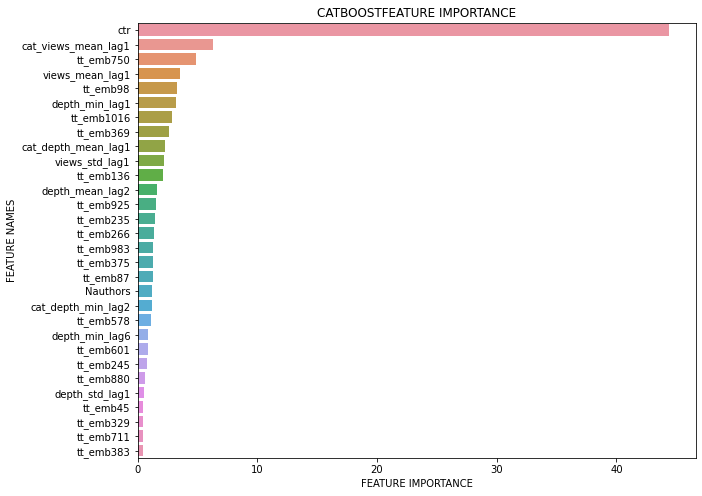

In [19]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_ds_views.get_feature_names(), 'CATBOOST')

## depth

In [20]:
cb_model_depth = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_ds_depth,
                   eval_set=val_ds_depth, 
                   #plot = True,
                  )

0:	learn: 0.0643786	test: 0.0579895	best: 0.0579895 (0)	total: 3.19s	remaining: 5m 15s
1:	learn: 0.0626312	test: 0.0562461	best: 0.0562461 (1)	total: 6.15s	remaining: 5m 1s
2:	learn: 0.0608683	test: 0.0544753	best: 0.0544753 (2)	total: 9.23s	remaining: 4m 58s
3:	learn: 0.0592393	test: 0.0530249	best: 0.0530249 (3)	total: 12.7s	remaining: 5m 4s
4:	learn: 0.0577622	test: 0.0515243	best: 0.0515243 (4)	total: 16.2s	remaining: 5m 7s
5:	learn: 0.0565170	test: 0.0504621	best: 0.0504621 (5)	total: 19.6s	remaining: 5m 6s
6:	learn: 0.0552185	test: 0.0491422	best: 0.0491422 (6)	total: 22.7s	remaining: 5m 2s
7:	learn: 0.0539246	test: 0.0480561	best: 0.0480561 (7)	total: 26.2s	remaining: 5m 1s
8:	learn: 0.0526636	test: 0.0468975	best: 0.0468975 (8)	total: 29.3s	remaining: 4m 55s
9:	learn: 0.0515493	test: 0.0458702	best: 0.0458702 (9)	total: 32.3s	remaining: 4m 51s
10:	learn: 0.0504567	test: 0.0449663	best: 0.0449663 (10)	total: 35.4s	remaining: 4m 46s
11:	learn: 0.0494965	test: 0.0440780	best: 0.04

In [21]:
# Get predictions and metrics
preds_train_depth = cb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = cb_model_depth.predict(val_ds_depth)

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8493920704127192, 0.7508125364228887)

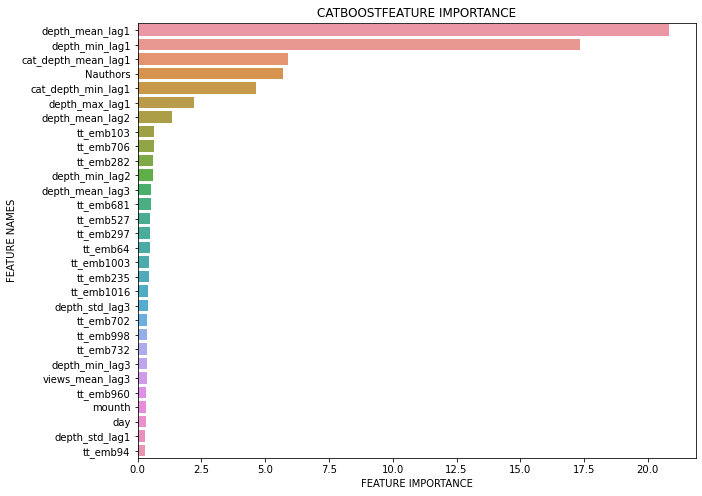

In [22]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_ds_depth.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [23]:
cb_model_frp = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_ds_frp,
                   eval_set=val_ds_frp, 
                   #plot = True,
                  )

0:	learn: 10.0448380	test: 10.1301260	best: 10.1301260 (0)	total: 2.79s	remaining: 4m 36s
1:	learn: 9.9311969	test: 10.0437579	best: 10.0437579 (1)	total: 5.6s	remaining: 4m 34s
2:	learn: 9.8271206	test: 9.9590121	best: 9.9590121 (2)	total: 8.46s	remaining: 4m 33s
3:	learn: 9.7287505	test: 9.8789366	best: 9.8789366 (3)	total: 11.3s	remaining: 4m 30s
4:	learn: 9.6231607	test: 9.7982387	best: 9.7982387 (4)	total: 14.3s	remaining: 4m 31s
5:	learn: 9.5246113	test: 9.7205075	best: 9.7205075 (5)	total: 17.1s	remaining: 4m 27s
6:	learn: 9.4352900	test: 9.6430707	best: 9.6430707 (6)	total: 19.9s	remaining: 4m 23s
7:	learn: 9.3489194	test: 9.5753465	best: 9.5753465 (7)	total: 22.6s	remaining: 4m 20s
8:	learn: 9.2665419	test: 9.5129997	best: 9.5129997 (8)	total: 25.4s	remaining: 4m 16s
9:	learn: 9.1817253	test: 9.4627351	best: 9.4627351 (9)	total: 28.2s	remaining: 4m 13s
10:	learn: 9.1022736	test: 9.4083034	best: 9.4083034 (10)	total: 30.9s	remaining: 4m 10s
11:	learn: 9.0285363	test: 9.3558914	

In [24]:
# Get predictions and metrics
preds_train_frp = cb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = cb_model_frp.predict(val_ds_frp)

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.647004026945631, 0.3381891575082846)

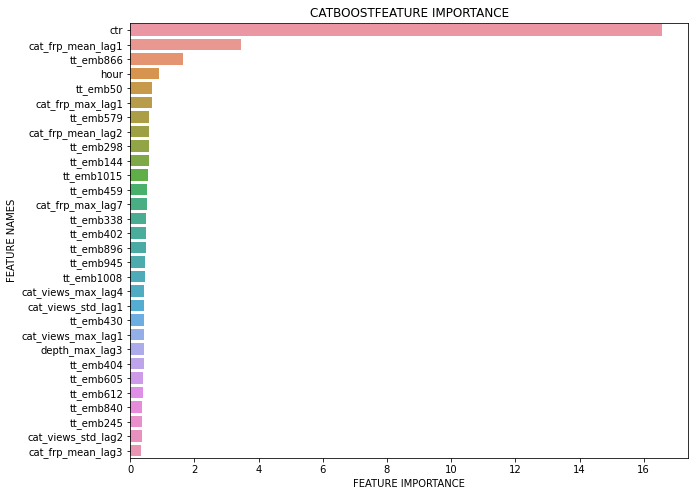

In [25]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_ds_frp.get_feature_names(), 'CATBOOST')

In [26]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6661157519992797, 0.48755208933038424)

In [28]:
NTRY = 6

## save models

In [29]:
cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_cb_views.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NTRY}_cb_depth.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NTRY}_cb_frp.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [30]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [31]:
subm = pd.DataFrame()
subm['document_id'] = df_test.index

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [32]:
subm.head()

,document_id,views,depth,full_reads_percent
0,0,21962.206852,1.161584,37.396553
1,1,13442.089310,1.059208,28.592472
2,2,13232.259815,1.059418,30.516706
3,3,14040.582570,1.063948,36.572453
4,4,154037.518560,1.161816,31.566852


In [33]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_cb_ttls_emd_lags.csv'), index = False)